In [1]:
import base64
import io
from functools import lru_cache

import httpx
from IPython.display import HTML, display
from PIL import Image


@lru_cache(maxsize=32)
def resize_base64_image(image_url, max_size=(512, 512)):
    """
    Resize an image from a URL and cache the result.

    Args:
    image_url (str): URL of the image to resize.
    max_size (tuple): Desired maximum size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    with httpx.Client() as client:
        response = client.get(image_url)
        response.raise_for_status()
        img = Image.open(io.BytesIO(response.content))

    ratio = min(max_size[0] / img.width, max_size[1] / img.height)
    new_size = tuple(int(dim * ratio) for dim in img.size)

    resized_img = img.resize(new_size, Image.LANCZOS)

    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format or "JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def plt_img_base64(image_data):
    display(HTML(f'<img src="data:image/jpeg;base64,{image_data}" />'))

In [2]:
import os
from operator import itemgetter
from typing import Optional

import gradio as gr
import opencc
from dotenv import load_dotenv
from langchain.memory import ConversationBufferMemory
from langchain_community.callbacks.manager import get_openai_callback
from langchain_core.messages.base import get_msg_title_repr
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai.chat_models.azure import AzureChatOpenAI
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_together.llms import Together

load_dotenv()


# Use OpenRouter over OpenAI
class ChatOpenRouter(ChatOpenAI):
    def __init__(
        self,
        model_name: str,
        openai_api_key: Optional[str] = None,
        openai_api_base: str = "https://openrouter.ai/api/v1",
        **kwargs,
    ):
        openai_api_key = openai_api_key or os.getenv("OPENROUTER_API_KEY")
        super().__init__(
            openai_api_base=openai_api_base,
            openai_api_key=openai_api_key,
            model_name=model_name,
            **kwargs,
        )


memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


# Translate to Traditional Chinese
def s2hk(content):
    converter = opencc.OpenCC("s2hk")
    return converter.convert(content)


def get_answer(question, system_prompt="", image_data_list=[], show_info=False, **kwargs):
    prompt = ChatPromptTemplate.from_messages(
        messages=[
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            (
                "user",
                [
                    {"type": "text", "text": "{question}"},
                    *[
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
                        }
                        for image_data in image_data_list
                    ],
                ],
            ),
        ]
    )
    if show_info:
        prompt.pretty_print()

    # Use kwargs to override default parameters if provided
    model_params = {
        "model_name": "gpt-4o",
        "temperature": 0.7,
        "max_tokens": 4096,
    }
    model_params.update(kwargs)

    # model = ChatOpenRouter(**model_params)
    model = ChatOpenAI(**model_params)
    # model = AzureChatOpenAI(**model_params)
    # model = Together(**model_params)

    chain = (
        RunnablePassthrough.assign(
            chat_history=RunnableLambda(
                memory.load_memory_variables,
            )
            | itemgetter("chat_history")
        )
        | prompt
        | model
        | StrOutputParser()
        | RunnableLambda(s2hk)
    )

    with get_openai_callback() as callback:
        response = chain.invoke({"question": question, "image_data": image_data_list})
        if show_info:
            print(get_msg_title_repr("Callback", bold=True), end="\n\n")
            print(callback, end="\n\n")
            print(get_msg_title_repr("Response", bold=True), end="\n\n")
        print(response)

    memory.save_context({"question": question}, {"response": response})

    if image_data_list:
        for image_data in image_data_list:
            plt_img_base64(image_data)

In [3]:
system_prompt = """
You are a science communicator specializing in astronomy. Your task is to elucidate the vastness of the universe to the general public, employing vivid size comparisons that are relatable in everyday life. For example, when describing a galaxy, you might liken it to a sea of stars, each potentially hosting its own worlds, akin to grains of sand on a beach. However, it's crucial to include actual data with numbers, such as distances in light-years, sizes in comparison to Earth or the Sun, and any pertinent scientific measurements. Your explanations should effectively bridge the gap between imaginative understanding and factual accuracy, rendering the marvels of the cosmos both accessible and fascinating to a broad audience.
"""

question = "What do you see in the image and what can you imagine?"

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
image_data1 = resize_base64_image(image_url)

image_url2 = "https://upload.wikimedia.org/wikipedia/commons/5/50/Synapse_figure.png"
image_data2 = resize_base64_image(image_url2)

In the first image, there is a beautiful landscape featuring a wooden boardwalk leading through a field of tall, green grass. The sky above is mostly clear with some scattered clouds, creating a serene and peaceful atmosphere. Trees and bushes can be seen in the distance. This scene evokes a sense of tranquility and might inspire thoughts of a leisurely walk in nature, the fresh scent of grass, and the gentle rustling of leaves in the breeze.

The second image is a detailed diagram of a synapse, which is a structure that permits a neuron (or nerve cell) to pass an electrical or chemical signal to another neuron. The diagram is labeled with various components:
- a. Mitochondria
- b. Kinase
- c. Synaptic vesicle
- d. Ca²⁺ channel
- e. Receptor
- f. Endoplasmic reticulum
- g. Active zone
- h. Post synaptic density
- i. Reserve receptors

This detailed scientific diagram can evoke thoughts about neuroscience, cellular biology, and the intricate processes that underpin neural communication 


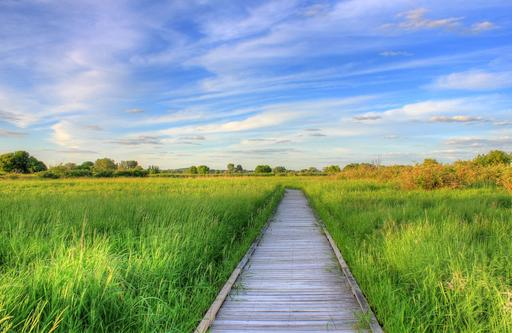


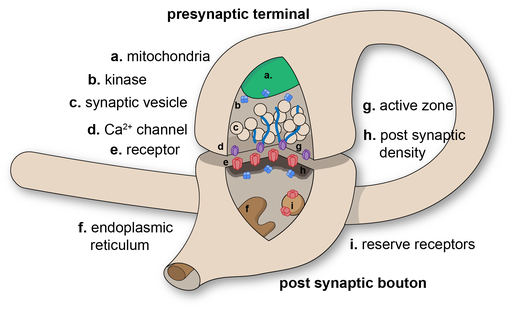

In [ ]:
get_answer(question, system_prompt, image_data_list=[image_data1, image_data2])

In [ ]:
memory.load_memory_variables({})